In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
import csv
value = []
with open("cleaned/new_ny.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        value.append(int(i[2]))

value.reverse()
data = value

train  = value[:-200]
test = value[-200:]


# 设置序列数据的时间跨度，seq=7, 指使用过去七天的数据来预测明天的数据
# 注意，这并不是说LSTM每次都只利用到7天的历史数据进行预测，而是7天的显式数据+所有已输入的数据产生的隐式信息（只是隐式信息具有离当前预测距离越远，信息量越弱的特点，详情看下行链接）
# https://www.jianshu.com/p/6815da2d413d 关于RNN的长距离依赖问题，看下这个链接，LSTM比RNN在这方面强很多，但问题仍然存在。


seq = 7

# 训练集构造

li_x = []
li_y = []

for i in range(len(train) - seq):
    # 输入就是[x, x+1, x+2, ... , x + (seq-1)]天的数据，输出是 x + seq 天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

# 对数据进行缩放有利于训练的收敛，但更好的方式是进行归一化处理；在当前应用上，这几种操作对结果不会造成太大影响，可以作为以后的练习。
# 关于归一化的作用，可以参考这个帖子：https://www.cnblogs.com/LBSer/p/4440590.html

train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)


# 测试集构造

t_x = []
t_y = []

for i in range(len(test) - seq):
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [12]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003) #Learning Rate
loss_fun = nn.MSELoss()

In [13]:
model.train()
list_l = []
list_tl = []
for epoch in range(3000):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    list_l.append(loss)
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        list_tl.append(test_loss)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))

epoch:20, loss:2.0514609813690186, test_loss: 69.1478271484375
epoch:40, loss:0.6273854970932007, test_loss: 55.054351806640625
epoch:60, loss:0.524077832698822, test_loss: 49.37378692626953
epoch:80, loss:0.5041456818580627, test_loss: 46.953670501708984
epoch:100, loss:0.49327322840690613, test_loss: 45.57099151611328
epoch:120, loss:0.4811599850654602, test_loss: 44.665802001953125
epoch:140, loss:0.466309517621994, test_loss: 43.68238067626953
epoch:160, loss:0.44678643345832825, test_loss: 42.553245544433594
epoch:180, loss:0.42141422629356384, test_loss: 41.196495056152344
epoch:200, loss:0.3894859552383423, test_loss: 39.56711959838867
epoch:220, loss:0.35330650210380554, test_loss: 37.77520751953125
epoch:240, loss:0.32261449098587036, test_loss: 36.134918212890625
epoch:260, loss:0.30379554629325867, test_loss: 34.92390441894531
epoch:280, loss:0.2905830144882202, test_loss: 34.20063018798828
epoch:300, loss:0.2790567874908447, test_loss: 33.722137451171875
epoch:320, loss:0.2

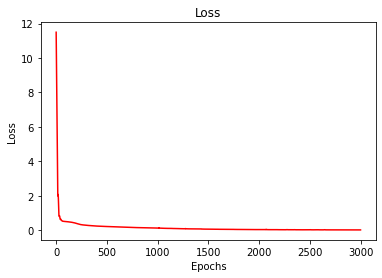

In [14]:
num_list = []
for i in range(len(list_l)):
    num_list.append(list_l[i].item())
x = np.array([i for i in range(len(list_l))])
#print(num_list)
plt.plot(x, num_list, color='r')
#plt.plot(x, num_list_, color='k')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('plot/NY_Loss.jpg')
plt.show()

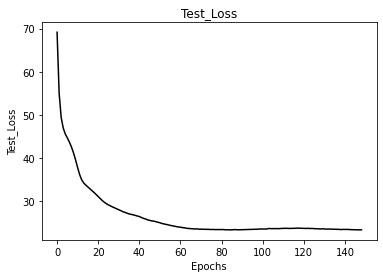

In [15]:
num_list_ = []
for i in range(len(list_tl)):
    num_list_.append(list_tl[i].item())
x = np.array([i for i in range(len(num_list_))])
#plt.plot(x, num_list, color='r')
plt.plot(x, num_list_, color='k')
plt.title('Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Test_Loss')
plt.savefig('plot/NY_Test_Loss.jpg')
plt.show()

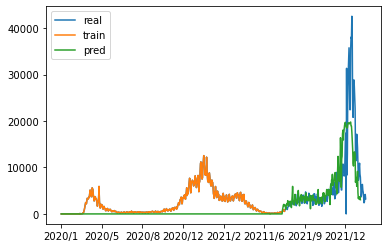

In [16]:
model.eval()
# result = li_x[0][:seq-1] + list((model(train_x).data.reshape(-1))*1000) + list((model(test_x).data.reshape(-1))*1000)
result = [0] + list((model(train_x).data.reshape(-1))*00) + list((model(test_x).data.reshape(-1))*1000)
#展示结果
plt.plot(data,label="real")
# 原来的走势

plt.plot(train,label="train")

plt.plot(result,label="pred")
plt.xticks(
    [0,100,200,300,400,500,600,700],
    ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '20211/6', '2021/9', '2021/12']
)
# 模型预测的走势
plt.legend(loc='best')
plt.savefig('plot/NY_Epoch1200.jpg')

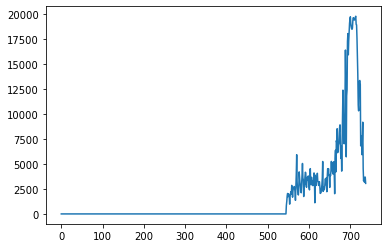

In [17]:
plt.plot(result)

In [18]:
# unpredictive
# 

In [19]:
from sklearn.metrics import mean_squared_error
temp_MSE = []
temp_RMSE = []
for i in range(500,700,100):
    MSE = mean_squared_error(result[i:i+100], data[i:i+100])
    temp_MSE.append(MSE)
    RMSE = MSE ** 0.5
    temp_RMSE.append(RMSE)
print(temp_MSE, sum(temp_MSE)/ 2)
print(temp_RMSE, sum(temp_RMSE) / 2)

[614125.1652985754, 8899278.184970377] 4756701.675134476
[783.6613843354637, 2983.1657991084535] 1883.4135917219587
